In [1]:
import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from skimage.feature import peak_local_max
from collections import Counter
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torchvision
import numpy as np
import json
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import random
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import KFold,train_test_split
import matplotlib.pyplot as plt
import glob
import gc
import os  
from torchvision import transforms
import pickle


In [2]:
ls

drive/  sample_data/


In [3]:
cd drive/MyDrive/Kuzushiji\ Recognition/

/content/drive/MyDrive/Kuzushiji Recognition


In [4]:
sample_submission=pd.read_csv("sample_submission.csv")
sample_submission.head()

image_id                 labels   Useage
0  test_001c37e2  U+003F 1 1 U+FF2F 2 2  Private
1  test_003aa33a  U+003F 1 1 U+FF2F 2 2   Public
2  test_00665e33  U+003F 1 1 U+FF2F 2 2  Private
3  test_0082d2cd  U+003F 1 1 U+FF2F 2 2  Private
4  test_0086f578  U+003F 1 1 U+FF2F 2 2  Private

In [5]:
train=pd.read_csv("train.csv")
train.head()

image_id                                             labels
0  100241706_00004_2  U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1  100241706_00005_1  U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2  100241706_00005_2  U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3  100241706_00006_1  U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4  100241706_00007_2  U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...

In [6]:
unicode_translation=pd.read_csv("unicode_translation.csv")
unicode_map = {Unicode: char for Unicode, char in unicode_translation.values}

In [ ]:
#### Ici on rempli un dictionnaire avec les labels pour chaque image

dictionnary_labels_per_image = {}
for image_id in train['image_id'].values:
    size = cv2.imread('train_images/{}.jpg'.format(image_id)).shape
    labels = train[train['image_id']==image_id].labels.values[0].split(' ')
    letters = []
    bbox = []
  
    for i,l in enumerate(labels[::5]):
        letters.append(l)
        bbox.append([int(x) for x in labels[i*5+1:i*5+5]])

    dictionnary_labels_per_image[image_id]={"letters":letters,"bbox":bbox,"size":size}

In [7]:

# with open('dictionnary_labels_per_image.pickle', 'wb') as handle:
#     pickle.dump(dictionnary_labels_per_image, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('dictionnary_labels_per_image.pickle', 'rb') as handle:
    dictionnary_labels_per_image = pickle.load(handle)

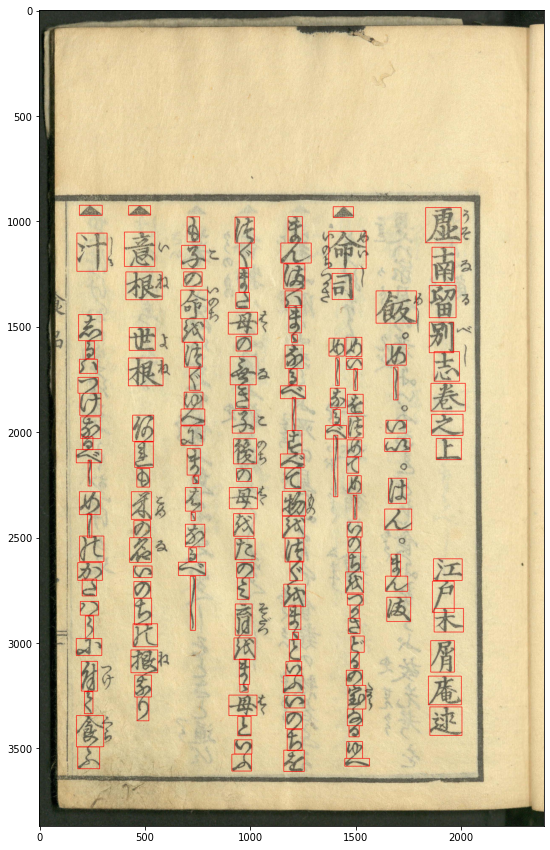

In [8]:
def image_visualization(image_id, viz=False):    
    if viz==True:
        img = cv2.imread('train_images/{}.jpg'.format(image_id))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for elements in dictionnary_labels_per_image[image_id]["bbox"]:
            cv2.rectangle(img, (elements[0], elements[1]), (elements[0]+elements[2], elements[1]+elements[3]), (255, 0, 0), 2)
        plt.figure(figsize=(15, 15))
        imgplot = plt.imshow(img)
    

image_visualization("100241706_00007_2", viz=True)

In [9]:
### How can I optimize it
def gaussian_heatmap(sigma, center_x, center_y, heatmap):
#     for i in range(heatmap.shape[0]):
#         for j in range(heatmap.shape[1]):
#             gaussian = np.exp(-((j-center_x)*(j-center_x)+(i-center_y)*(i-center_y))/(2*sigma*sigma))
#             if gaussian > heatmap[i, j]:
#                 heatmap[i,j]=gaussian
                
    point = np.exp(-(np.arange(128)-center_x)**2/(2*sigma*sigma)).reshape(1,-1
                                                                         )*np.exp(-(np.arange(128)-center_y)**2/(2*sigma*sigma)).reshape(-1,1)
    heatmap=np.maximum(heatmap,point)
    return heatmap


In [10]:
def generate_heatmap_offset(image_id, sigma):
    heatmap = np.zeros((128, 128))
    offset_x = np.zeros((128, 128))
    offset_y = np.zeros((128, 128))
    object_size_x =  np.zeros((128, 128))
    object_size_y =  np.zeros((128, 128))
    bbox = dictionnary_labels_per_image[image_id]["bbox"]
    img_shape = dictionnary_labels_per_image[image_id]["size"]
    
    for i in range(len(bbox)):
        center_x = bbox[i][0]+bbox[i][2]//2
        center_y = bbox[i][1]+bbox[i][3]//2

        center_x_resized_float = center_x/img_shape[1] * 128
        center_y_resized_float = center_y/img_shape[0] * 128
        
        center_x_resized_int = int(center_x_resized_float)
        center_y_resized_int = int(center_y_resized_float)
        
        heatmap = gaussian_heatmap(sigma, center_x_resized_int, center_y_resized_int, heatmap)
        offset_x[center_y_resized_int, center_x_resized_int] = center_x_resized_float - center_x_resized_int
        offset_y[center_y_resized_int, center_x_resized_int] = center_y_resized_float - center_y_resized_int
        object_size_x[center_y_resized_int, center_x_resized_int] = bbox[i][2]//2
        object_size_y[center_y_resized_int, center_x_resized_int] = bbox[i][3]//2
        
    return heatmap, offset_x, offset_y, object_size_x, object_size_y

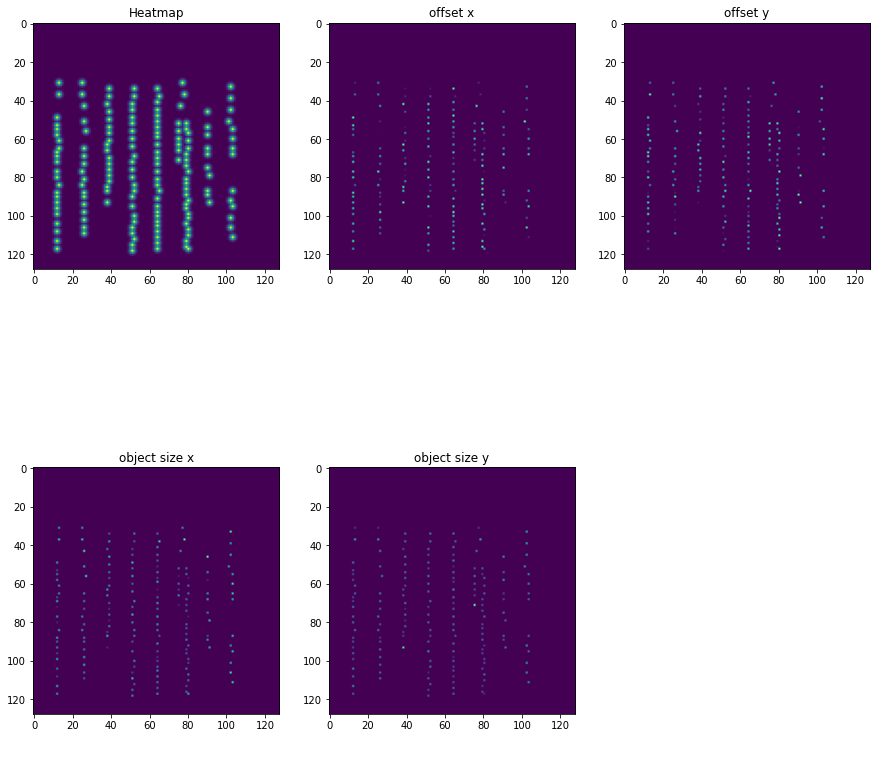

In [11]:
heatmap, offset_x, offset_y, object_size_x, object_size_y = generate_heatmap_offset("100241706_00007_2",1)

fig, axes = plt.subplots(2, 3,figsize=(15,15))
axes[0,0].set_title('Heatmap')
axes[0,0].imshow(heatmap)
axes[0,1].set_title('offset x')
axes[0,1].imshow(offset_x)
axes[0,2].set_title('offset y')
axes[0,2].imshow(offset_y)
axes[1,0].set_title('object size x')
axes[1,0].imshow(object_size_x)
axes[1,1].set_title('object size y')
axes[1,1].imshow(object_size_y)
axes[1,2].set_axis_off()

plt.show()

In [ ]:
# heatmaps = []
# offsets_x = []
# offsets_y = []
# object_sizes_x = []
# object_sizes_y = []

# training = {}
# for image_id in train.image_id:
#     gc.collect()
#     heatmap, offset_x, offset_y, object_size_x, object_size_y = generate_heatmap_offset(image_id, 1)
#     img = np.resize(cv2.imread('train_images/{}.jpg'.format(image_id)),(512,512))

#     ## Petite erreur ici, j'aurai du resize avant de creer les heatmaps
#     training[image_id] = {"image":img,"heatmap":heatmap,"offset_x":offset_x,"offset_y":offset_y,
#                         "object_size_x":object_size_x,"object_size_y":object_size_y}
    

In [ ]:
# with open('training.pickle', 'wb') as handle:
#     pickle.dump(training, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # with open('dictionnary_labels_per_image.pickle', 'rb') as handle:
# #     dictionnary_labels_per_image = pickle.load(handle)

In [12]:
gc.collect()

2442

In [13]:
def heatmap_to_image(heatmap, offset_x, offset_y, object_size_x, object_size_y,image_id):
    coordinates = peak_local_max(heatmap, min_distance=9)
    img = cv2.imread('train_images/{}.jpg'.format(image_id)) 
    ratio_x = img.shape[0]/heatmap.shape[0]
    ratio_y = img.shape[1]/heatmap.shape[1]

    for i,coords in enumerate(coordinates):
        bbox_x1=int((coordinates[i][0]+offset_y[coords[0],coords[1]])*ratio_x - object_size_y[coords[0],coords[1]])
        bbox_y1=int((coordinates[i][1]+offset_x[coords[0],coords[1]])*ratio_y- object_size_x[coords[0],coords[1]])
        width_x = int(bbox_x1+object_size_y[coords[0],coords[1]]*2)
        width_y = int(bbox_y1+object_size_x[coords[0],coords[1]]*2)
        cv2.rectangle(img, (bbox_y1, bbox_x1), (width_y, width_x), (255, 0, 0), 2)
    #coordinates_adjusted = np.stack((coordinates[:,0]*ratio_x,coordinates[:,1]*ratio_y),axi=1).astype(int)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15, 15))
    imgplot = plt.imshow(img)

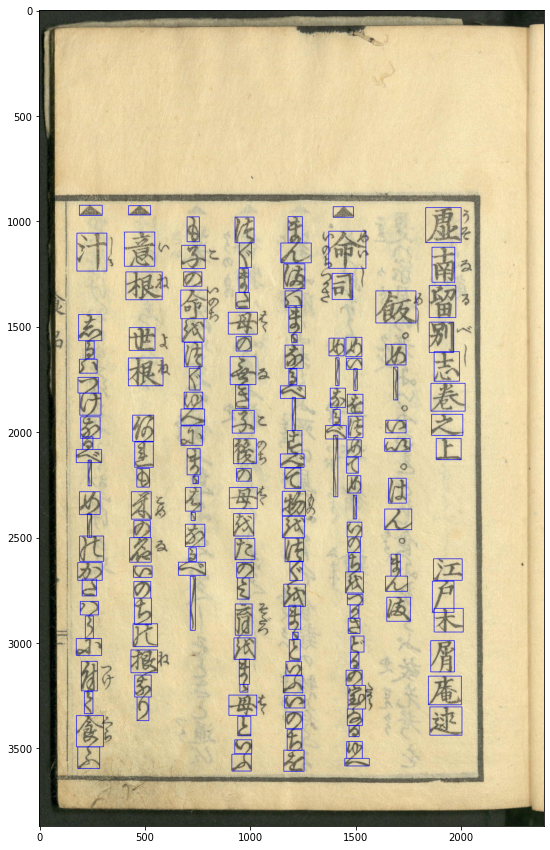

In [14]:
heatmap_to_image(heatmap, offset_x, offset_y, object_size_x, object_size_y,"100241706_00007_2")

In [15]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)
        
    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x

class centernet(nn.Module):
    def __init__(self, n_classes=1, model_name="resnet18"):
        super(centernet, self).__init__()
        # create backbone.
        basemodel = torchvision.models.resnet18(pretrained=True) # turn this on for training
        basemodel = nn.Sequential(*list(basemodel.children())[:-2])
        # set basemodel
        self.base_model = basemodel
        
        if model_name == "resnet34" or model_name=="resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        
        self.up1 = up(num_ch, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 256)
        # output classification
        self.outc = nn.Conv2d(256, n_classes, 1)
        # output residue
        self.outr = nn.Conv2d(256, 2, 1) 
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.base_model(x)
        
        # Add positional info        
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        outc = self.outc(x)
        outr = self.outr(x)
        return outc, outr

In [16]:
### Let's define our losses 

def neg_loss(pred, gt):
    ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
    Arguments:
      pred (batch x c x h x w)
      gt_regr (batch x c x h x w)
    '''
    pred = pred.unsqueeze(1).float()
    gt = gt.unsqueeze(1).float()

    pos_inds = gt.eq(1).float()
    neg_inds = gt.lt(1).float()
    neg_weights = torch.pow(1 - gt, 4)

    loss = 0

    pos_loss = torch.log(pred + 1e-12) * torch.pow(1 - pred, 3) * pos_inds
    neg_loss = torch.log(1 - pred + 1e-12) * torch.pow(pred, 3) * neg_weights * neg_inds

    num_pos  = pos_inds.float().sum()
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    if num_pos == 0:
      loss = loss - neg_loss
    else:
      loss = loss - (pos_loss + neg_loss) / num_pos
    return loss

def _reg_loss(regr, gt_regr, mask):
    ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
    '''
    num = mask.float().sum()
    #print(gt_regr.size())
    mask = mask.sum(1).unsqueeze(1).expand_as(gt_regr)
    #print(mask.size())

    regr = regr * mask
    gt_regr = gt_regr * mask

    regr_loss = nn.functional.smooth_l1_loss(regr, gt_regr, size_average=False)
    regr_loss = regr_loss / (num + 1e-4)
    return regr_loss

def centerloss(prediction, mask, regr,weight=0.4, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
    mask_loss = neg_loss(pred_mask, mask)
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
  
    # Sum
    loss = mask_loss +regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

In [46]:
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = (image.astype(np.float32)/255)
        image -= self.mean
        image /= self.std
        return image

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_id):
        self.img_id = img_id
        self.normalize = Normalize()
        

    def __getitem__(self, index):
      
        img = cv2.resize(cv2.imread('train_images/{}.jpg'.format(self.img_id[index])),(512,512))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        heatmap, offset_x, offset_y, object_size_x, object_size_y = generate_heatmap_offset(self.img_id[index], 1)
        regr = np.zeros((2, 128, 128))
        regr[0,:,:]=object_size_x
        regr[1,:,:]=object_size_y
        return img,self.img_id[index], heatmap, regr
    
    def __len__(self):
        return len(self.img_id)

class DatasetTest(torch.utils.data.Dataset):
    def __init__(self, img_id):
        self.img_id = img_id
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, index):

        img = cv2.resize(cv2.imread('test_images/{}'.format(self.img_id[index])),(512,512))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        return img, self.img_id[index]

traindataset = MyDataset(train.image_id.values)

### Change number of workers to 4 and set pin_memory = True
### If you want a variable to not use graph tree use .detach() insted of .numpy() or .float()
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=20,shuffle=True, num_workers=4,
                                           pin_memory = True)

testdataset = DatasetTest(os.listdir("test_images"))
test_loader = torch.utils.data.DataLoader(testdataset,batch_size=20,shuffle=False, num_workers=4,
                                          pin_memory = True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [47]:
gc.collect()

136

In [18]:
def train_model(epoch):
    model.train()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_mask = 0.0
    running_regr = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    for idx, (img,index, hm, regr) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        regr_gt = regr.to(device)
        # set opt
        ## set_to_none=True apparently optimizes the memory usage
        optimizer.zero_grad(set_to_none=True)
        
        # run model
        hm, regr = model(img)
        preds = torch.cat((hm, regr), 1)
            
        loss, mask_loss, regr_loss = centerloss(preds, hm_gt, regr_gt)
        # misc
        running_loss += loss
        running_mask += mask_loss
        running_regr += regr_loss
        
        loss.backward()
        optimizer.step()
        
        t.set_description(f't (l={running_loss/(idx+1):.3f})(m={running_mask/(idx+1):.4f})(r={running_regr/(idx+1):.4f})')
        
    #scheduler.step()
    print('train loss : {:.4f}'.format(running_loss/len(train_loader)))
    print('maskloss : {:.4f}'.format(running_mask/(len(train_loader))))
    print('regrloss : {:.4f}'.format(running_regr/(len(train_loader))))
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                    'loss': running_loss/len(train_loader), "mask": running_mask/(len(train_loader)), 
                 "regr": running_regr/(len(train_loader))}
    logs.append(log_epoch)

In [52]:
gc.collect()

4967

In [53]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = centernet()
# model.to(device)

import torch.optim as optim
model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 10
logs = []
logs_eval = []
TRAIN = True
if TRAIN:
    for epoch in range(epochs):
        train_model(epoch)
        torch.save(model.state_dict(), "model")
        gc.collect()
else:
    model.load_state_dict(torch.load(MODEL_PATH))

torch.save(model.state_dict(), "model")


### Around 40 epochs runned
### Mask loss fell to 0.1041 and regrloss fell to 6.4058 and train loss to 6.5094

epochs 1/10 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



train loss : 7.2285
maskloss : 0.1096
regrloss : 7.1189
epochs 2/10 



train loss : 7.0735
maskloss : 0.1082
regrloss : 6.9653
epochs 3/10 



train loss : 6.9662
maskloss : 0.1074
regrloss : 6.8588
epochs 4/10 



train loss : 6.8357
maskloss : 0.1062
regrloss : 6.7295
epochs 5/10 



train loss : 6.7051
maskloss : 0.1050
regrloss : 6.6000
epochs 6/10 



train loss : 6.5932
maskloss : 0.1041
regrloss : 6.4891
epochs 7/10 



train loss : 6.5094
maskloss : 0.1036
regrloss : 6.4058
epochs 8/10 



train loss : 6.4073
maskloss : 0.1024
regrloss : 6.3049
epochs 9/10 



train loss : 6.3073
maskloss : 0.1016
regrloss : 6.2057
epochs 10/10 



train loss : 6.2430
maskloss : 0.1011
regrloss : 6.1419


In [ ]:
model = centernet()
model.load_state_dict(torch.load("model"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [20]:
def heatmap_to_image_test(heatmap,object_size_x, object_size_y,image_id):
    coordinates = peak_local_max(heatmap, min_distance=9)
    img = cv2.resize(cv2.imread('test_images/{}'.format(image_id)),(512,512)) 
    ratio_x = img.shape[0]/heatmap.shape[0]
    ratio_y = img.shape[1]/heatmap.shape[1]

    for i,coords in enumerate(coordinates):
        bbox_x1=int((coordinates[i][0])*ratio_x - object_size_y[coords[0],coords[1]])
        bbox_y1=int((coordinates[i][1])*ratio_y- object_size_x[coords[0],coords[1]])
        width_x = int(bbox_x1+object_size_y[coords[0],coords[1]]*2)
        width_y = int(bbox_y1+object_size_x[coords[0],coords[1]]*2)
        cv2.rectangle(img, (bbox_y1, bbox_x1), (width_y, width_x), (255, 0, 0), 2)
    print(object_size_x[coords[0],coords[1]])
    #coordinates_adjusted = np.stack((coordinates[:,0]*ratio_x,coordinates[:,1]*ratio_y),axi=1).astype(int)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15, 15))
    imgplot = plt.imshow(img)

In [21]:
def heatmap_to_image_train(heatmap, object_size_x, object_size_y,image_id):
    coordinates = peak_local_max(heatmap, min_distance=9)
    img = cv2.imread('train_images/{}.jpg'.format(image_id)) 
    ratio_x = img.shape[0]/heatmap.shape[0]
    ratio_y = img.shape[1]/heatmap.shape[1]

    for i,coords in enumerate(coordinates):
        bbox_x1=int((coordinates[i][0])*ratio_x - object_size_y[coords[0],coords[1]])
        bbox_y1=int((coordinates[i][1])*ratio_y- object_size_x[coords[0],coords[1]])
        width_x = int(bbox_x1+object_size_y[coords[0],coords[1]]*2)
        width_y = int(bbox_y1+object_size_x[coords[0],coords[1]]*2)
        cv2.rectangle(img, (bbox_y1, bbox_x1), (width_y, width_x), (255, 0, 0), 2)
    #coordinates_adjusted = np.stack((coordinates[:,0]*ratio_x,coordinates[:,1]*ratio_y),axi=1).astype(int)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15, 15))
    imgplot = plt.imshow(img)

In [58]:
l = iter(train_loader)
example = next(l)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [59]:
img_id = example[1][0]
img = example[0][0]
model.eval()
with torch.no_grad():
      hm, regr = model(img.to(device).float().unsqueeze(0))

  
hm = hm.cpu().numpy().squeeze(0).squeeze(0)
regr = regr.cpu().numpy().squeeze(0)

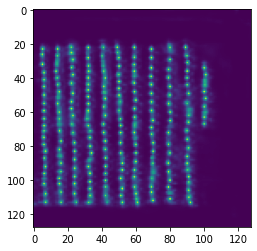

In [60]:
m = torch.sigmoid(torch.from_numpy(hm)).numpy()
plt.imshow(m)
plt.show()

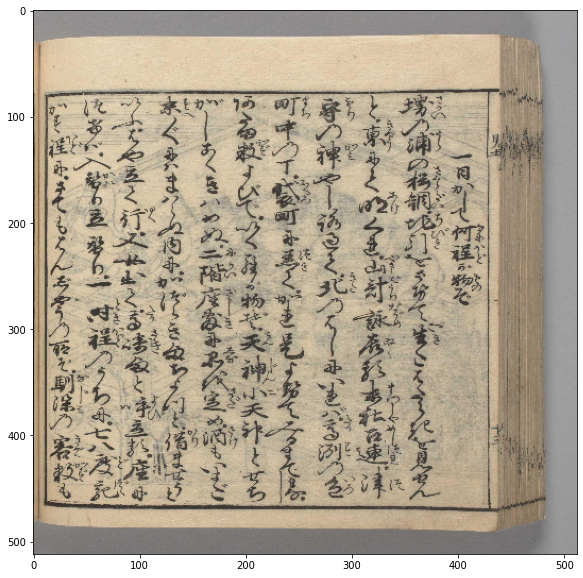

In [61]:
img = cv2.resize(cv2.imread('train_images/{}.jpg'.format(img_id)),(512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img)

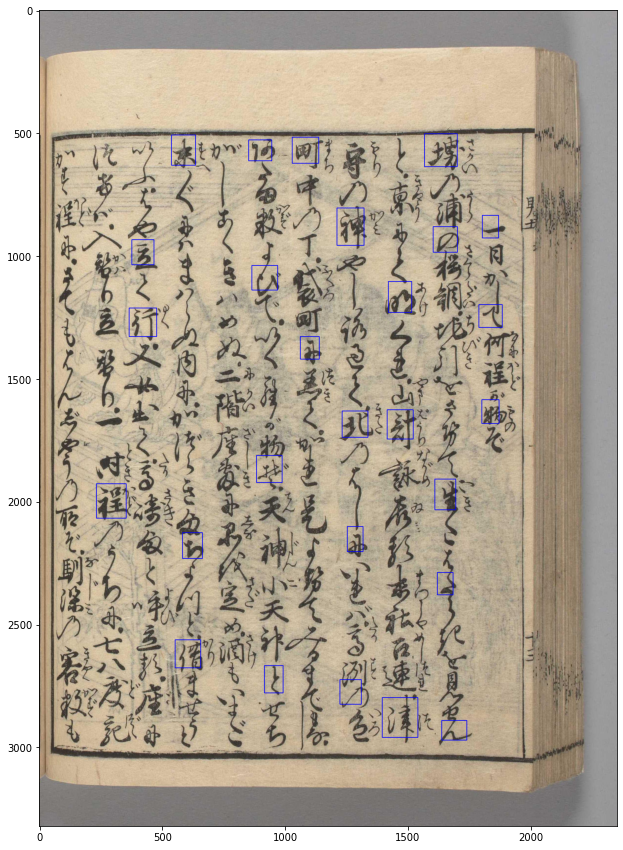

In [62]:
heatmap_to_image_train(hm,regr[0],regr[1],img_id)